#About Notebook

This notebook implement vanilla LSTM model as a baseline for the stock price movement prediction.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g5SLhRcmsiUpbbD7DKWKitEKpNIeGkflidjf-c6HmZ-S5jBzRwPj_s


## Data

To reduce the training time, we will only use the ticks in January


Preprocess Method:
* Fit the dataframe according to the batch size multiple
* Scaling with Minmax Scaler
* 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ADL final project/data/final_input.csv', index_col = [0])
df.head()

,Open,Close,High,Low,Volume_x,Volume_y,MA,Returns,BBand_upper,BBand_middle,BBand_lower,Average Directional Index,Directional Index,MACD,MACD_signal,MACD hist,stochastic k,stochastic d,movement
0,297.3300,297.325,297.3300,297.3250,0.0225,0.0400,297.035000,0.000388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,297.2400,297.165,297.2400,297.1600,0.1050,0.0412,297.132857,0.000329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,297.9000,297.660,297.9250,297.5145,3.0150,2.6786,297.265714,0.000447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,297.6695,297.785,297.8155,297.5945,3.1800,2.8610,297.403214,0.000462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,297.7850,297.815,297.9255,297.6850,3.0375,2.3263,297.468214,0.000219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
train_size = int(len(df) * .7)
df_train =  df.iloc[:train_size]
df_val = df.iloc[train_size:]

print(len(df_train), len(df_val))

65218 27951


In [ ]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

feature_columns = ['Open', 'High', 'Low', 'Volume_x', 'Volume_y', 'MA', 'Returns',
       'BBand_upper', 'BBand_middle', 'BBand_lower', 'Directional Index',
       'Average Directional Index', 'MACD', 'MACD_signal', 'MACD hist',
        'stochastic k', 'stochastic d']
      
for feature in feature_columns:
  df_train[feature] = scaler.fit_transform(df_train[[feature]].values)
  df_val[feature] = scaler.transform(df_val[[feature]])

In [ ]:
from tensorflow.keras.utils import to_categorical

Y_train = df_train['movement']
Y_val = df_val['movement']

print(len(Y_train[Y_train == 1]), len(Y_train[Y_train == 0]))
print(len(Y_val[Y_val == 1]), len(Y_val[Y_val == 0]))

Y_train = to_categorical(Y_train, 2)
Y_val = to_categorical(Y_val, 2)

34209 31009
14165 13786


In [ ]:
def convert_raw_samples_to_model_samples(scd_log_rtns, movements, window_size):
    X, y = [], []
    len_log_rtns = len(scd_log_rtns)
    for i in range(window_size, len_log_rtns):
        X.append(scd_log_rtns[i-window_size:i])
        y.append(movements[i])
    X, y = np.asarray(X), np.asarray(y)
    #X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y


In [ ]:
df_train = df_train.dropna()
df_train.index = np.arange(0,len(df_train))
df_val.index = np.arange(0,len(df_val))

df_train = df_train[feature_columns]
df_val  = df_val[feature_columns]

In [ ]:
window_size = 256
X_train, y_train = convert_raw_samples_to_model_samples(df_train, Y_train, window_size)
X_val, y_val = convert_raw_samples_to_model_samples(df_val, Y_val, window_size)
#X_test, y_test = convert_raw_samples_to_model_samples(test_values, test_y_values, window_size)

## Embedding

Reference: [paper](https://arxiv.org/pdf/1907.05321.pdf), [code](https://github.com/JanSchm/CapMarket)

In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
# -*- coding: utf-8 -*-
"""Confusion matrix.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1dbeSXmnx5b6mUMXXYMlYVw-V20-fDdPc
"""

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Model

##LSTM 

In [ ]:
def create_LSTM(X, classification, embedding):
  if len(X.shape) == 2:
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  input_seq = Input(shape = (X.shape[1], X.shape[2]))

  if embedding:
    time_embedding = Time2Vector(X.shape[1])
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    x = LSTM(64, return_sequences= False)(x)
  else:
    x = LSTM(64, return_sequences= False)(input_seq)
  
  if classification:
    x = Dropout(0.1)(x)
    x = Dense(128, activation = 'relu')(x)
    #out = Dense(1, activation = 'softmax')(x)
    out = Dense(2, activation="softmax", name="output")(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-5), metrics = ['acc',f1_m,precision_m, recall_m])
  else:
    x = Dropout(0.1)(x)
    out = Dense(1)(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(1e-5), metrics = ['mae', 'mape'])
  
  return model

In [ ]:
#With Time Embedding
lstm_time = create_LSTM(X_train, True, True)
lstm_notime = create_LSTM(X_train, True, False)

In [ ]:
history_time = lstm_time.fit(X_train, y_train,epochs=5, validation_data=(X_val, y_val))
history_notime = lstm_notime.fit(X_train, y_train,epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
2030/2030 [==============================] - 36s 15ms/step - loss: 0.6934 - acc: 0.5087 - f1_m: 0.5087 - precision_m: 0.5087 - recall_m: 0.5087 - val_loss: 0.6835 - val_acc: 0.6864 - val_f1_m: 0.6865 - val_precision_m: 0.6865 - val_recall_m: 0.6865
Epoch 2/5
2030/2030 [==============================] - 29s 14ms/step - loss: 0.6926 - acc: 0.5226 - f1_m: 0.5226 - precision_m: 0.5226 - recall_m: 0.5226 - val_loss: 0.6858 - val_acc: 0.7022 - val_f1_m: 0.7022 - val_precision_m: 0.7022 - val_recall_m: 0.7022
Epoch 3/5
2030/2030 [==============================] - 29s 14ms/step - loss: 0.6923 - acc: 0.5211 - f1_m: 0.5211 - precision_m: 0.5211 - recall_m: 0.5211 - val_loss: 0.6883 - val_acc: 0.6318 - val_f1_m: 0.6316 - val_precision_m: 0.6316 - val_recall_m: 0.6316
Epoch 4/5
2030/2030 [==============================] - 29s 14ms/step - loss: 0.6920 - acc: 0.5238 - f1_m: 0.5238 - precision_m: 0.5238 - recall_m: 0.5238 - val_loss: 0.6898 - val_acc: 0.5803 - val_f1_m: 0.5801 - val_precisi

In [ ]:
y_pred_time = lstm_time.predict(X_val)
y_pred_notime = lstm_notime.predict(X_val)

y_pred_time = [y_pred_time[i].argmax() for i in range(len(y_pred_time))]
y_pred_notime = [y_pred_notime[i].argmax() for i in range(len(y_pred_notime))]



In [ ]:
from sklearn.metrics import classification_report
y_true =  [y_val[i].argmax() for i in range(len(y_val))]
print('with Embedding')
print(classification_report(y_true, y_pred_time))
print('--------------------------')
print('without Embedding')
print(classification_report(y_true, y_pred_notime))

with Embedding
              precision    recall  f1-score   support

           0       0.65      0.28      0.39     13679
           1       0.55      0.86      0.67     14016

    accuracy                           0.57     27695
   macro avg       0.60      0.57      0.53     27695
weighted avg       0.60      0.57      0.53     27695

--------------------------
without Embedding
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     13679
           1       0.51      1.00      0.67     14016

    accuracy                           0.51     27695
   macro avg       0.25      0.50      0.34     27695
weighted avg       0.26      0.51      0.34     27695



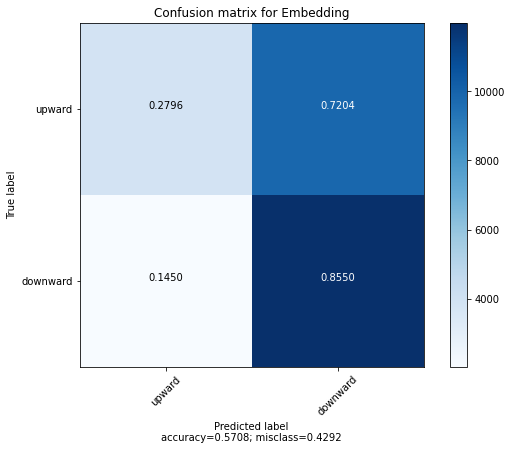

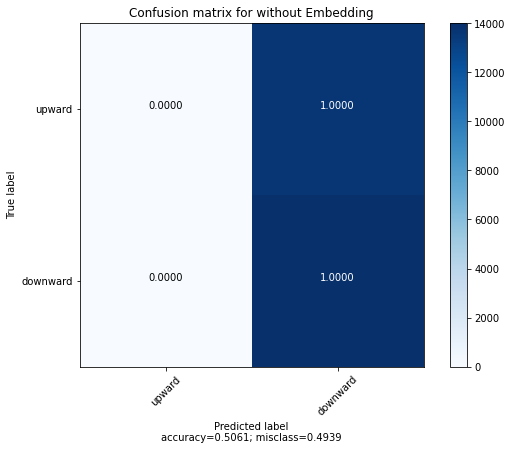

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_time)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix for Embedding',
                      cmap=None,
                      normalize=True)

cm = confusion_matrix(y_true, y_pred_notime)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix for without Embedding',
                      cmap=None,
                      normalize=True)

In [28]:
final_result = pd.DataFrame()
final_result['y_true'] = y_true
final_result['lstm_with_time'] = y_pred_time
final_result['lstm_without_time'] = y_pred_notime
final_result.to_csv('/content/drive/MyDrive/ADL final project/data/lstm_output.csv')

## Transformers

In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [ ]:
def create_transformers(X, embedding, classification):
  
  d_k = 256
  d_v = 256
  n_heads = 12
  ff_dim = 256

  input_seq = Input(shape = (X.shape[1], X.shape[2]))

  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  if embedding:
    time_embedding = Time2Vector(X.shape[1])
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    x = attn_layer1((x,x,x))
  else:
    x = attn_layer1((input_seq, input_seq, input_seq))
  
  x = attn_layer2((x,x,x))
  x = attn_layer3((x,x,x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)

  if classification:
    out = Dense(2, activation="softmax", name="output")(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-5), metrics = ['accuracy'])
  else:
    out = Dense(1)(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'mse', optimizer = 'Adam', metrics = ['mae', 'mape'])
  
  return model


In [ ]:
X_train, y_train = convert_raw_samples_to_model_samples(df_train, Y_train, 64)
X_val, y_val = convert_raw_samples_to_model_samples(df_val, Y_val, 64)

In [ ]:
#With Time Embedding
model = create_transformers(X_train, True, True)

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 17)]     0                                            
__________________________________________________________________________________________________
time2_vector_5 (Time2Vector)    (None, 64, 2)        256         input_9[0][0]                    
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 64, 19)       0           input_9[0][0]                    
                                                                 time2_vector_5[0][0]             
__________________________________________________________________________________________________
transformer_encoder_6 (Transfor (None, 64, 19)       252786      concatenate_5[0][0]        

In [ ]:
history = model.fit(X_train, y_train,epochs=5,  validation_data=(X_val, y_val))

Epoch 1/5
 312/2029 [===>..........................] - ETA: 8:03 - loss: 0.6931 - accuracy: 0.5295

In [ ]:
y_pred = model.predict(X_val)
y_pred = [y_pred[i].argmax() for i in range(len(y_pred))]
print(set(y_pred))

num =[0,0]
for i in range(len(y_pred)):
  num[y_pred[i]] += 1 

print(num)

y_true =  [y_val[i].argmax() for i in range(len(y_val))]
num =[0,0]
for i in range(len(y_true)):
  num[y_true[i]] += 1 
print(num)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)

In [ ]:
#Without Time Embedding
model = create_transformers(X_train, False, True)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 17)]     0                                            
__________________________________________________________________________________________________
transformer_encoder_3 (Transfor (None, 64, 17)       227174      input_4[0][0]                    
                                                                 input_4[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
transformer_encoder_4 (Transfor (None, 64, 17)       227174      transformer_encoder_3[0][0]      
                                                                 transformer_encoder_3[0][0]

In [ ]:
history = model.fit(X_train, y_train,epochs=5,  validation_data=(X_val, y_val))

Epoch 1/5
2029/2029 [==============================] - 705s 338ms/step - loss: 0.6911 - accuracy: 0.5242 - val_loss: 0.6740 - val_accuracy: 0.5286
Epoch 2/5
2029/2029 [==============================] - 713s 352ms/step - loss: 0.6618 - accuracy: 0.5804 - val_loss: 0.6316 - val_accuracy: 0.6244
Epoch 3/5
2029/2029 [==============================] - 728s 359ms/step - loss: 0.6165 - accuracy: 0.6887 - val_loss: 0.5923 - val_accuracy: 0.6630
Epoch 4/5
2029/2029 [==============================] - 731s 360ms/step - loss: 0.5663 - accuracy: 0.7496 - val_loss: 0.5487 - val_accuracy: 0.7196
Epoch 5/5
2029/2029 [==============================] - 756s 373ms/step - loss: 0.5193 - accuracy: 0.7776 - val_loss: 0.5108 - val_accuracy: 0.7545


In [ ]:
y_pred = model.predict(X_val)
y_pred = [y_pred[i].argmax() for i in range(len(y_pred))]
print(set(y_pred))

num =[0,0]
for i in range(len(y_pred)):
  num[y_pred[i]] += 1 

print(num)

y_true =  [y_val[i].argmax() for i in range(len(y_val))]
num =[0,0]
for i in range(len(y_true)):
  num[y_true[i]] += 1 
print(num)
print(classification_report(y_true, y_pred))

{0, 1}
[8802, 18981]
[13615, 14168]
              precision    recall  f1-score   support

           0       0.89      0.57      0.70     13615
           1       0.69      0.93      0.79     14168

    accuracy                           0.75     27783
   macro avg       0.79      0.75      0.74     27783
weighted avg       0.79      0.75      0.75     27783



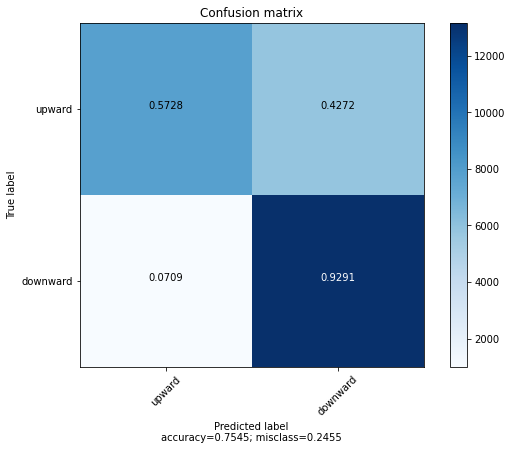

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)